# Modeling Coronavirus

Last updated 3/21/2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
import numpy as np
import pandas as pd
import pyviral

## Set some constants

In [2]:
# United States population
N = 327e6

# United States birth rate per day - 12 per 1000 per year
Alpha = 12/1000/365

# United States death rate per day - 8 per 1000 per year
Mu = 8/1000/365

# Numerical integration step
dt = 0.001

## Get data from  Johns Hopkins

Source: https://github.com/CSSEGISandData/COVID-19

In [3]:
confirmed_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
recovered_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"


In [4]:
# Download and munge
confirmed = pd.read_csv(confirmed_csv)
recovered = pd.read_csv(recovered_csv)
deaths = pd.read_csv(deaths_csv)

In [5]:
drop_cols = ["Province/State", "Country/Region", "Lat", "Long"]
def munge_us(data):
    return (data[(data['Country/Region'] == 'US') & 
              ~data['Province/State'].str.contains(',').fillna(False) &
              ~data['Province/State'].str.contains('Princess').fillna(False)]
            .drop(drop_cols, axis=1).sum(axis=0))
day1 = 48
confirmed_us = munge_us(confirmed).iloc[day1:]
recovered_us = munge_us(recovered).iloc[day1:]
deaths_us = munge_us(deaths).iloc[day1:]

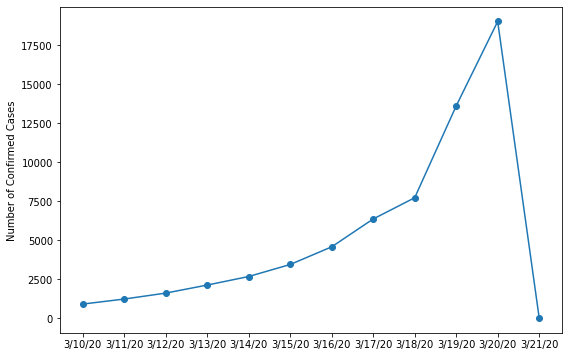

In [6]:
# Plot it
plt.plot(confirmed_us, 'o-')
plt.ylabel("Number of Confirmed Cases")
plt.show()

In [7]:
# Approximate the death rate.
death_rate = deaths_us[-2] / confirmed_us[-2]
death_rate

0.012823207904141265

## Find the parameters of the SIR model that match the data

Assuming the confirmed cases represents the real number of cumulative infections. This is a big assumption because testing is very limited.

Also assuming a 10% recovery rate.

Ignore birth rate, death rate, and immunity loss.

In [8]:
# Cumulative cases the number of new infections per day.
# It's also the same as n - s.
# But we have to account for the fact that the differential equations use the 
# number of current infections.
# It's easiest to find this numerically.
t = 10
I0 = confirmed_us.values[0]
gamma = 0.1
for betan in np.arange(.375, .38, .001):
    S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
    print(betan, N - S[-1], confirmed_us.values[-1])

0.375 18694.0 0.0
0.376 18868.0 0.0
0.377 19043.0 0.0
0.378 19221.0 0.0
0.379 19399.0 0.0
0.38 19580.0 0.0


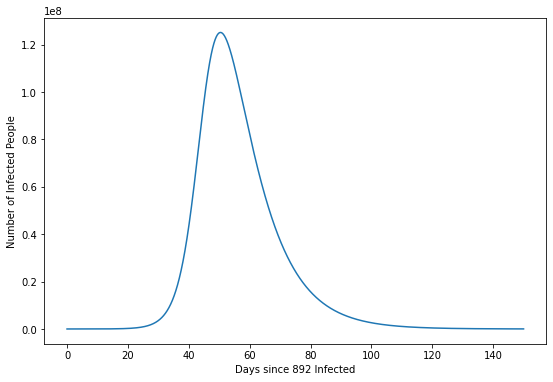

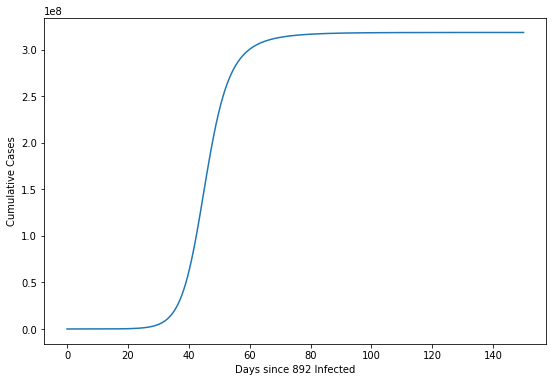

Infections peak at 125 million in 50 days.
A total of 318 million will be infected at some point.
There will be 4 million total deaths.


In [9]:
I0 = confirmed_us.values[0]
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
betan = 0.377
S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I)
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.show()

plt.plot(T, C)
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.show()
print("Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("There will be %i million total deaths." % (C[-1] / 1e6 * death_rate))

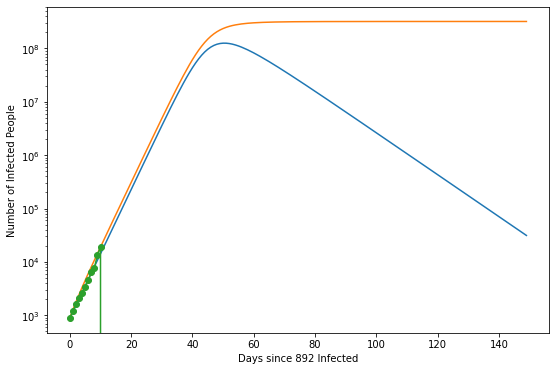

In [10]:
# Plotted on a log scale
daymap = T%1 == 0
plt.plot(T[daymap], I[daymap])
plt.plot(T[daymap], C[daymap])
plt.plot(np.arange(len(confirmed_us)), confirmed_us.values, 'o-')
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.yscale('log')
plt.show()

## What if the real number of infections is much larger than the confirmed number?

Because of lack of testing.

How much does this change beta? How does this change the dynamics?

In [11]:
# Define a new parameter, the testing rate.
# The number of known infections = tau * i
tau = 0.1 # Only 10% of the people who might be infected are getting tested.

In [12]:
# Now we want to match the cumulative known cases to the JHU data.
t = 10
I0 = confirmed_us.values[0] / tau
gamma = 0.1
for betan in np.arange(.37, .38, .001):
    S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
    print(betan, (N - S[-1]) * tau, confirmed_us.values[-1])

0.37 17841.100000000002 0.0
0.371 18006.5 0.0
0.372 18173.5 0.0
0.373 18342.100000000002 0.0
0.374 18512.3 0.0
0.375 18684.100000000002 0.0
0.376 18857.600000000002 0.0
0.377 19032.8 0.0
0.378 19209.600000000002 0.0
0.379 19388.2 0.0
0.38 19568.5 0.0


In [13]:
# We get the same value for beta. Probably could have found this with algebra. 

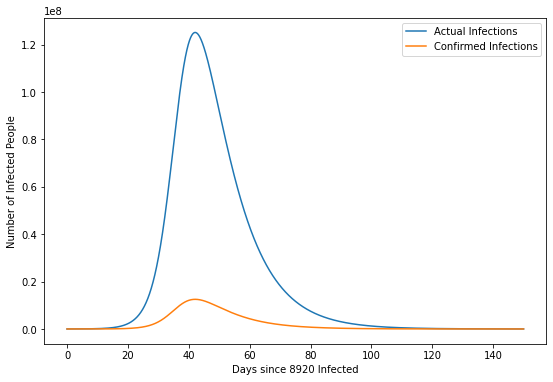

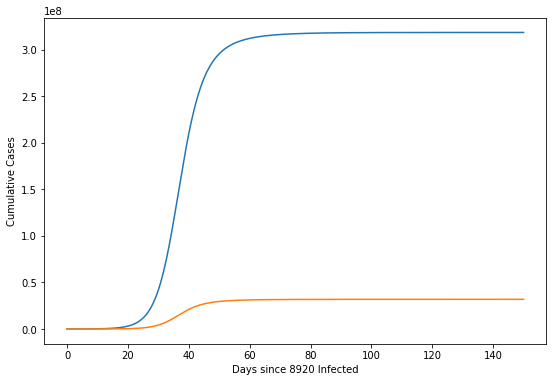

Confirmed Infections peak at 12 million in 42 days.
Actual Infections peak at 125 million in 42 days.
A total of 318 million will be infected at some point.
We'll only know about 31 million total cases if we don't improve testing.
There will be 408 thousand total deaths.


In [14]:
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.1
betan = 0.377
S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Actual Cumulative Cases")
plt.plot(T, C * tau, label="Confirmed Cumulative Cases")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.show()
print("Confirmed Infections peak at %i million in %i days." % (np.max(I) * tau / 1e6, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau * death_rate / 1e3))

## What if the recovery rate is higher?

If many of the undetected cases are mild, the average recovery rate could be a lot higher.

In [15]:
t = 10
I0 = confirmed_us.values[0] / tau
gamma = 0.3
for betan in np.arange(.52, .53, .001):
    S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
    print(betan, (N - S[-1]) * tau, confirmed_us.values[-1])

0.52 17794.100000000002 0.0
0.521 17940.3 0.0
0.522 18087.9 0.0
0.523 18236.9 0.0
0.524 18387.100000000002 0.0
0.525 18538.7 0.0
0.526 18691.7 0.0
0.527 18846.0 0.0
0.528 19001.8 0.0
0.529 19158.9 0.0
0.53 19317.5 0.0


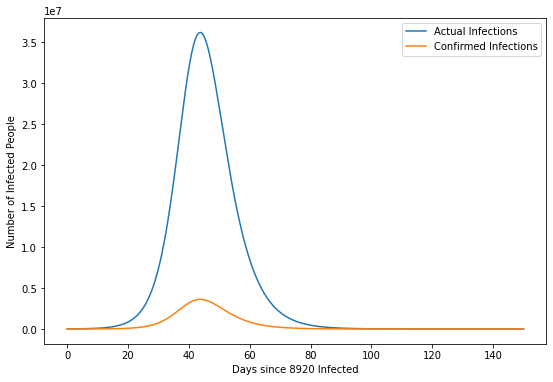

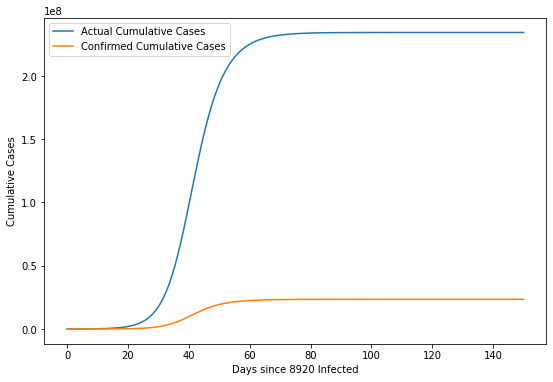

Confirmed Infections peak at 3 million in 43 days.
Actual Infections peak at 36 million in 43 days.
A total of 234 million will be infected at some point.
We'll only know about 23 million total cases if we don't improve testing.
There will be 300 thousand total deaths.


In [16]:
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.3
betan = 0.528
S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Actual Cumulative Cases")
plt.plot(T, C * tau, label="Confirmed Cumulative Cases")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()
print("Confirmed Infections peak at %i million in %i days." % (np.max(I) * tau / 1e6, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau  * death_rate/ 1e3))

## What if the missed cases is even more extreme?

tau = 0.01

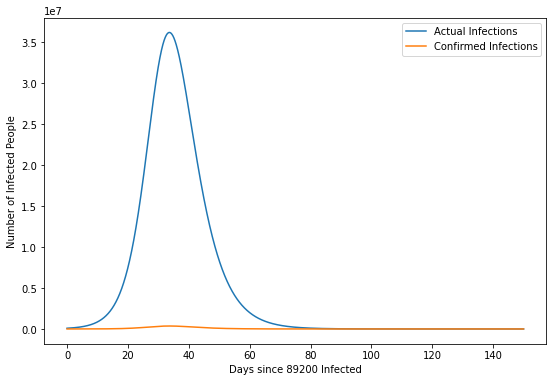

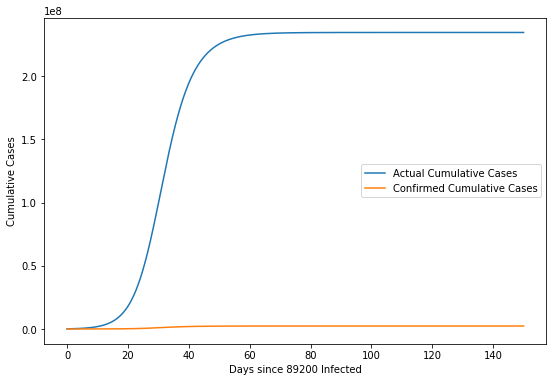

Confirmed Infections peak at 362 thousand in 33 days.
Actual Infections peak at 36 million in 33 days.
A total of 234 million will be infected at some point.
We'll only know about 2 million total cases if we don't improve testing.
There will be 30 thousand total deaths.


In [17]:
tau = 0.01
I0 = confirmed_us.values[0] / tau
S0 = N - I0
t = 150
T = np.arange(0, t, dt)
gamma = 0.3
betan = 0.528
S, I, R = pyviral.run(N - I0, I0, beta=betan / N, gamma=gamma, t=t, dt=dt)
# Cumulative cases is the same as people who are no longer susceptible
# if there is no immunity loss, births, or deaths.
C = N - S
plt.plot(T, I, label="Actual Infections")
plt.plot(T, I * tau, label="Confirmed Infections")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Number of Infected People")
plt.legend()
plt.show()

plt.plot(T, C, label="Actual Cumulative Cases")
plt.plot(T, C * tau, label="Confirmed Cumulative Cases")
plt.xlabel("Days since %i Infected" % I0)
plt.ylabel("Cumulative Cases")
plt.legend()
plt.show()
print("Confirmed Infections peak at %i thousand in %i days." % (np.max(I) * tau / 1e3, T[np.argmax(I)]))
print("Actual Infections peak at %i million in %i days." % (np.max(I) / 1e6, T[np.argmax(I)]))
print("A total of %i million will be infected at some point." % (C[-1] / 1e6))
print("We'll only know about %i million total cases if we don't improve testing." % (C[-1] * tau / 1e6))
print("There will be %i thousand total deaths." % (C[-1] * tau  * death_rate / 1e3))